In [1]:
import sys
import os
import jax
import jax.numpy as np
import jax.tree as jtu
import jax.random as jr
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Basic jax import
jax.config.update("jax_enable_x64", True)


# Check if running on remote, and set directory to where notebook is run
if jax.devices()[0].platform == "gpu":
    os.chdir("code/amigo_project/notebooks/calibration")

# Add parent directories
paths = [os.path.abspath(os.path.join(os.getcwd(), path)) for path in ['..', "../.."]]
for path in paths:
    if path not in sys.path:
        sys.path.insert(0, path)
        
# Plotting set up
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = mpl.colormaps["inferno"]
seismic = mpl.colormaps["seismic"]
coolwarm = mpl.colormaps["coolwarm"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)
coolwarm.set_bad("k", 0.5)


def merge_cbar(ax):
    return make_axes_locatable(ax).append_axes("right", size="5%", pad=0.0)

ERROR:2025-04-16 15:22:22,020:jax._src.xla_bridge:647: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/louis/miniconda3/envs/jax_gpu/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 645, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/home/louis/miniconda3/envs/jax_gpu/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 103, in initialize
    triton.register_compilation_handler(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'jax._src.lib.triton' has no attribute 'register_compilation_handler'


In [ ]:
import equinox as eqx
import dLux.utils as dlu
from jax import vmap
from amigo.misc import interp

def fft_coords(wl, npix, pscale, pad=2):
    x = np.fft.fftshift(np.fft.fftfreq(pad * npix, d=pscale / wl))
    return np.array(np.meshgrid(x, x))


def wf_fft_coords(wfs, pad=2):
    wls = wfs.wavelength
    psf_pscale = wfs.pixel_scale[0]
    psf_npix = wfs.npixels
    return vmap(lambda wl: fft_coords(wl, psf_npix, psf_pscale, pad=pad))(wls)


def vis_to_im(amps, phases, shape):
    # Conjugate the amplitudes and phases
    amp = 1.0 + np.concatenate([amps, np.array([0.0]), amps[::-1]], axis=0)
    phase = np.concatenate([phases, np.array([0.0]), -phases[::-1]], axis=0)
    return amp.reshape(shape), phase.reshape(shape)


def inject_vis(psfs, amps, phases, otf_coords, uv_coords):
    # Get the amplitudes and phases
    amp, phase = vis_to_im(amps, phases, otf_coords.shape[1:])

    # Build the visibility maps
    interp_fn = lambda im, uv, fill: interp(
        im, otf_coords, uv, method="linear", fill=fill
    )
    amps = vmap(lambda uv: interp_fn(amp, uv, fill=1.0))(uv_coords)
    phases = vmap(lambda uv: interp_fn(phase, uv, fill=0.0))(uv_coords)
    cplx = amps * np.exp(1j * phases)

    # Fourier Functions
    n = uv_coords.shape[-1] // 4
    pad_fn = lambda x: np.pad(x, n, mode="constant")
    crop_fn = lambda x: x[n:-n, n:-n]
    to_uv = vmap(lambda x: np.fft.fftshift(np.fft.fft2(pad_fn(x))))
    from_uv = vmap(lambda x: crop_fn(np.fft.ifft2(np.fft.ifftshift(x))))

    # Apply the visibility maps
    splodges = to_uv(psfs)
    applied = cplx * splodges
    return np.abs(from_uv(applied)).sum(0)

def model_vis_psf(optics, amp, phase, filter, aberrations, defocus, n_knots=51):
    #
    optics = optics.set(
        ["pupil_mask.abb_coeffs", "defocus"],
        [aberrations, defocus],
    )

    #
    wavels, weights = optics.filters[filter]
    wfs = eqx.filter_jit(optics.propagate)(wavels, weights=weights, return_wf=True)

    #
    otf_coords = dlu.pixel_coords(n_knots, 2 * optics.diameter)
    uv_coords = wf_fft_coords(wfs, pad=2)
    return inject_vis(wfs.psf, amp, phase, otf_coords, uv_coords)

In [50]:
from jax.flatten_util import ravel_pytree


def batched_jacobian(X, fn, n_batch=1):
    Xs = np.array_split(X, n_batch)
    rebuild = lambda X_batch, index: X.at[index : index + len(X_batch)].set(X_batch)
    lens = np.cumsum(np.array([len(x) for x in Xs]))[:-1]
    starts = np.concatenate([np.array([0]), lens])

    @eqx.filter_jacfwd
    def batched_jac_fn(x, index):
        return eqx.filter_jit(fn)(rebuild(x, index))

    return np.concatenate(
        [batched_jac_fn(x, index) for x, index in zip(Xs, starts)], axis=-1
    ).T


def decompose(J, values):
    # Get the covariance matrix
    cov = np.eye(values.size) * values[..., None]

    # Get the hessian
    hess = J @ (cov @ J.T)

    # Get the eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eig(hess)
    eigvecs, eigvals = np.real(eigvecs).T, np.real(eigvals)

    #
    eigvals /= eigvals[0]
    return hess, eigvals, eigvecs

In [51]:
from amigo.optical_models import AMIOptics

state = np.load("temp_state.npy", allow_pickle=True).item()

optics = AMIOptics(defocus_type="fft")

aberrations = {}
for key, value in state['aberrations'].items():
    prog, filt = key.split("_")
    if "04481" in prog:
        print(filt)
        aberrations[filt] = value

defocus = state["defocus"]
optics = optics.set(
    ["distortion", "primary_beam"], [state["distortion"], state["primary_beam"]]
)

F380M
F430M
F480M


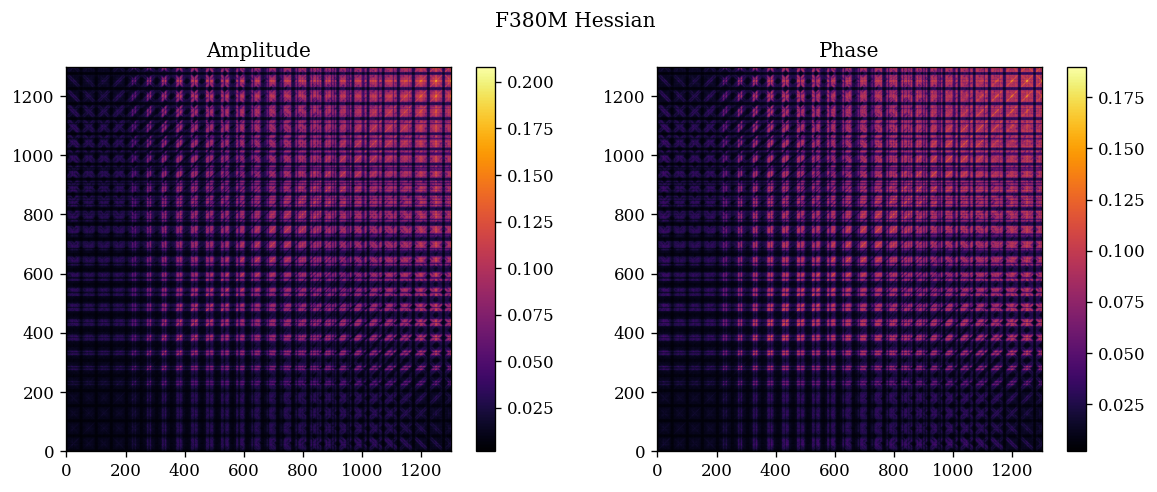

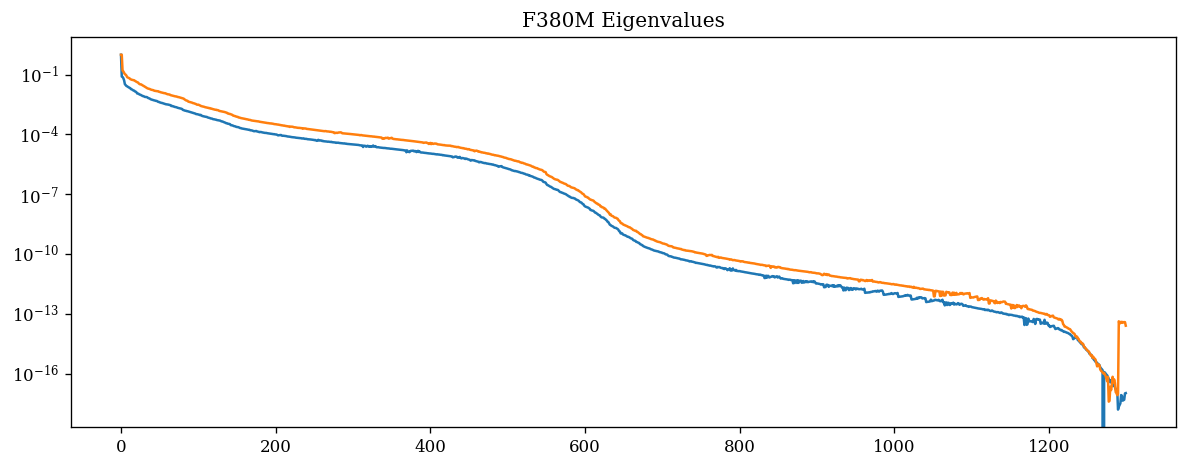

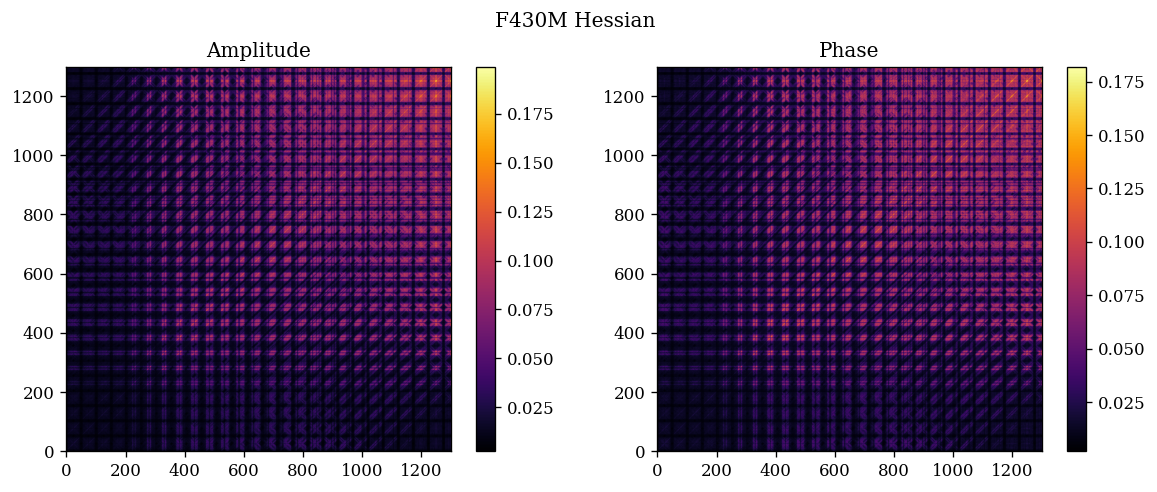

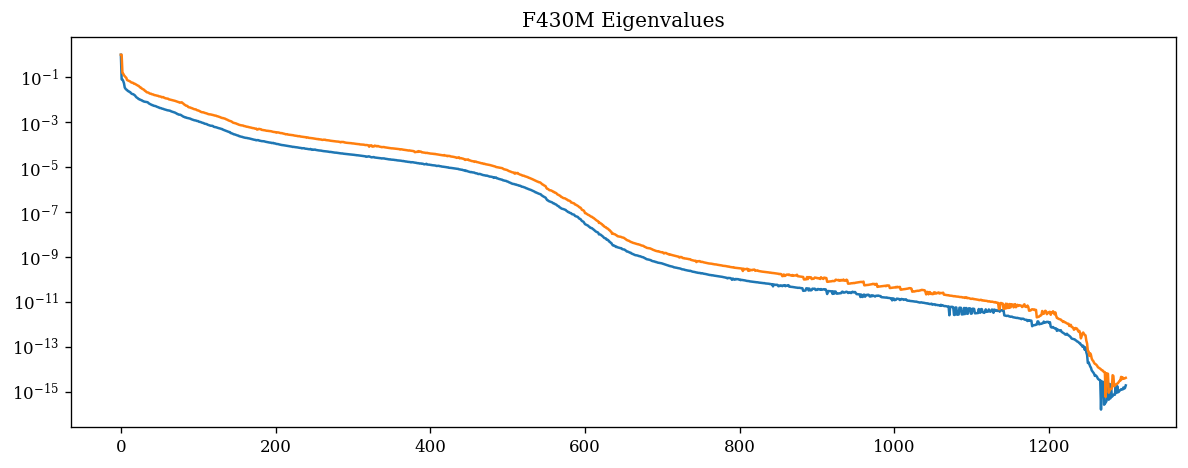

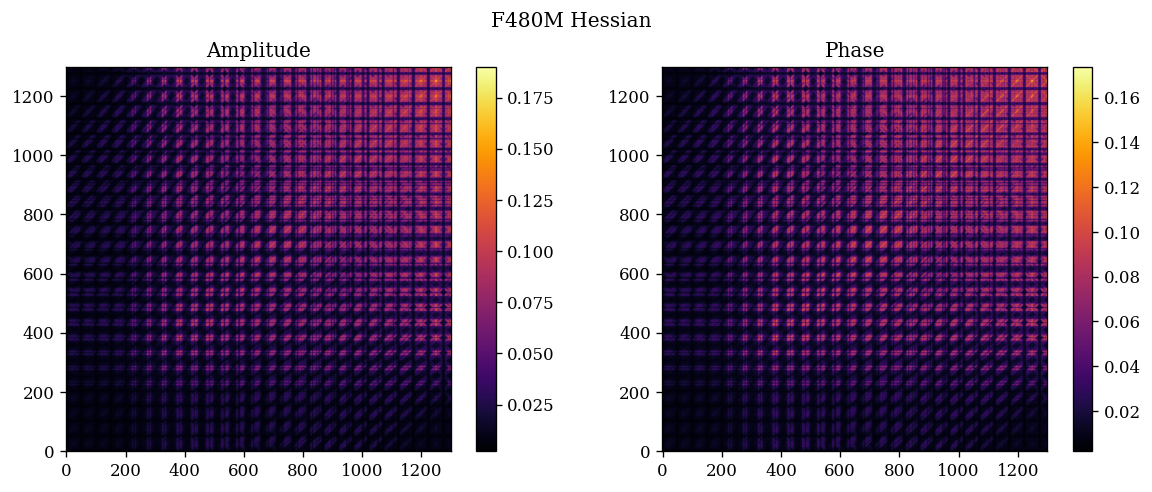

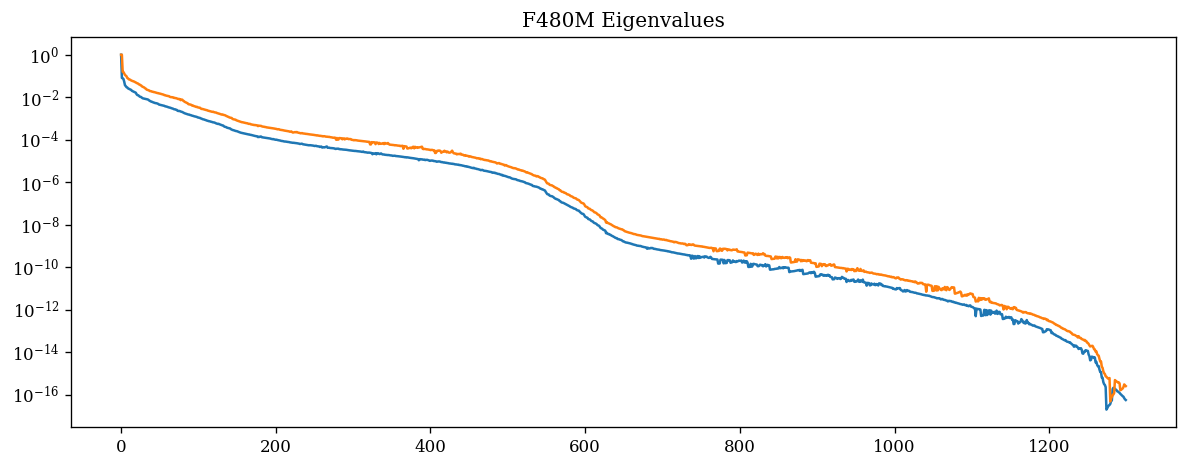

In [54]:
from amigo.misc import tqdm

n_terms = 250
eig_mats = {"amplitude": {}, "phase": {}}
for filt in ["F380M", "F430M", "F480M"]:
    n_knots = 51
    n_pts = (n_knots**2) // 2
    amp, phase = np.zeros((2, n_pts))
    abb = aberrations[filt]
    defoc = defocus[filt]

    # aberrations = np.zeros_like(abb_coeffs[filt])
    # defocus = np.zeros_like(state["defocus"][filt])

    output_fn = lambda x: dlu.downsample(x, 3, mean=False).flatten()
    vis_fn = lambda amp, phase: output_fn(
        model_vis_psf(optics, amp, phase, filt, abb, defoc, n_knots)
    )
    J_amp = batched_jacobian(amp, lambda X: vis_fn(X, phase), n_batch=10)
    J_phase = batched_jacobian(phase, lambda X: vis_fn(amp, X), n_batch=10)

    psf = vis_fn(amp, phase)
    H_amp, amp_vals, amp_vecs = decompose(J_amp, psf)
    H_phase, phase_vals, phase_vecs = decompose(J_phase, psf)
    eig_mats['amplitude'][filt] = amp_vecs
    eig_mats['phase'][filt] = phase_vecs

    plt.figure(figsize=(10, 4))
    plt.suptitle(f"{filt} Hessian")

    plt.subplot(1, 2, 1)
    plt.title("Amplitude")
    plt.imshow(np.abs(H_amp) ** 0.1, cmap="inferno")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title("Phase")
    plt.imshow(np.abs(H_phase) ** 0.1, cmap="inferno")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title(f"{filt} Eigenvalues")
    plt.plot(amp_vals, label="Amplitude")
    plt.plot(phase_vals, label="Phase")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

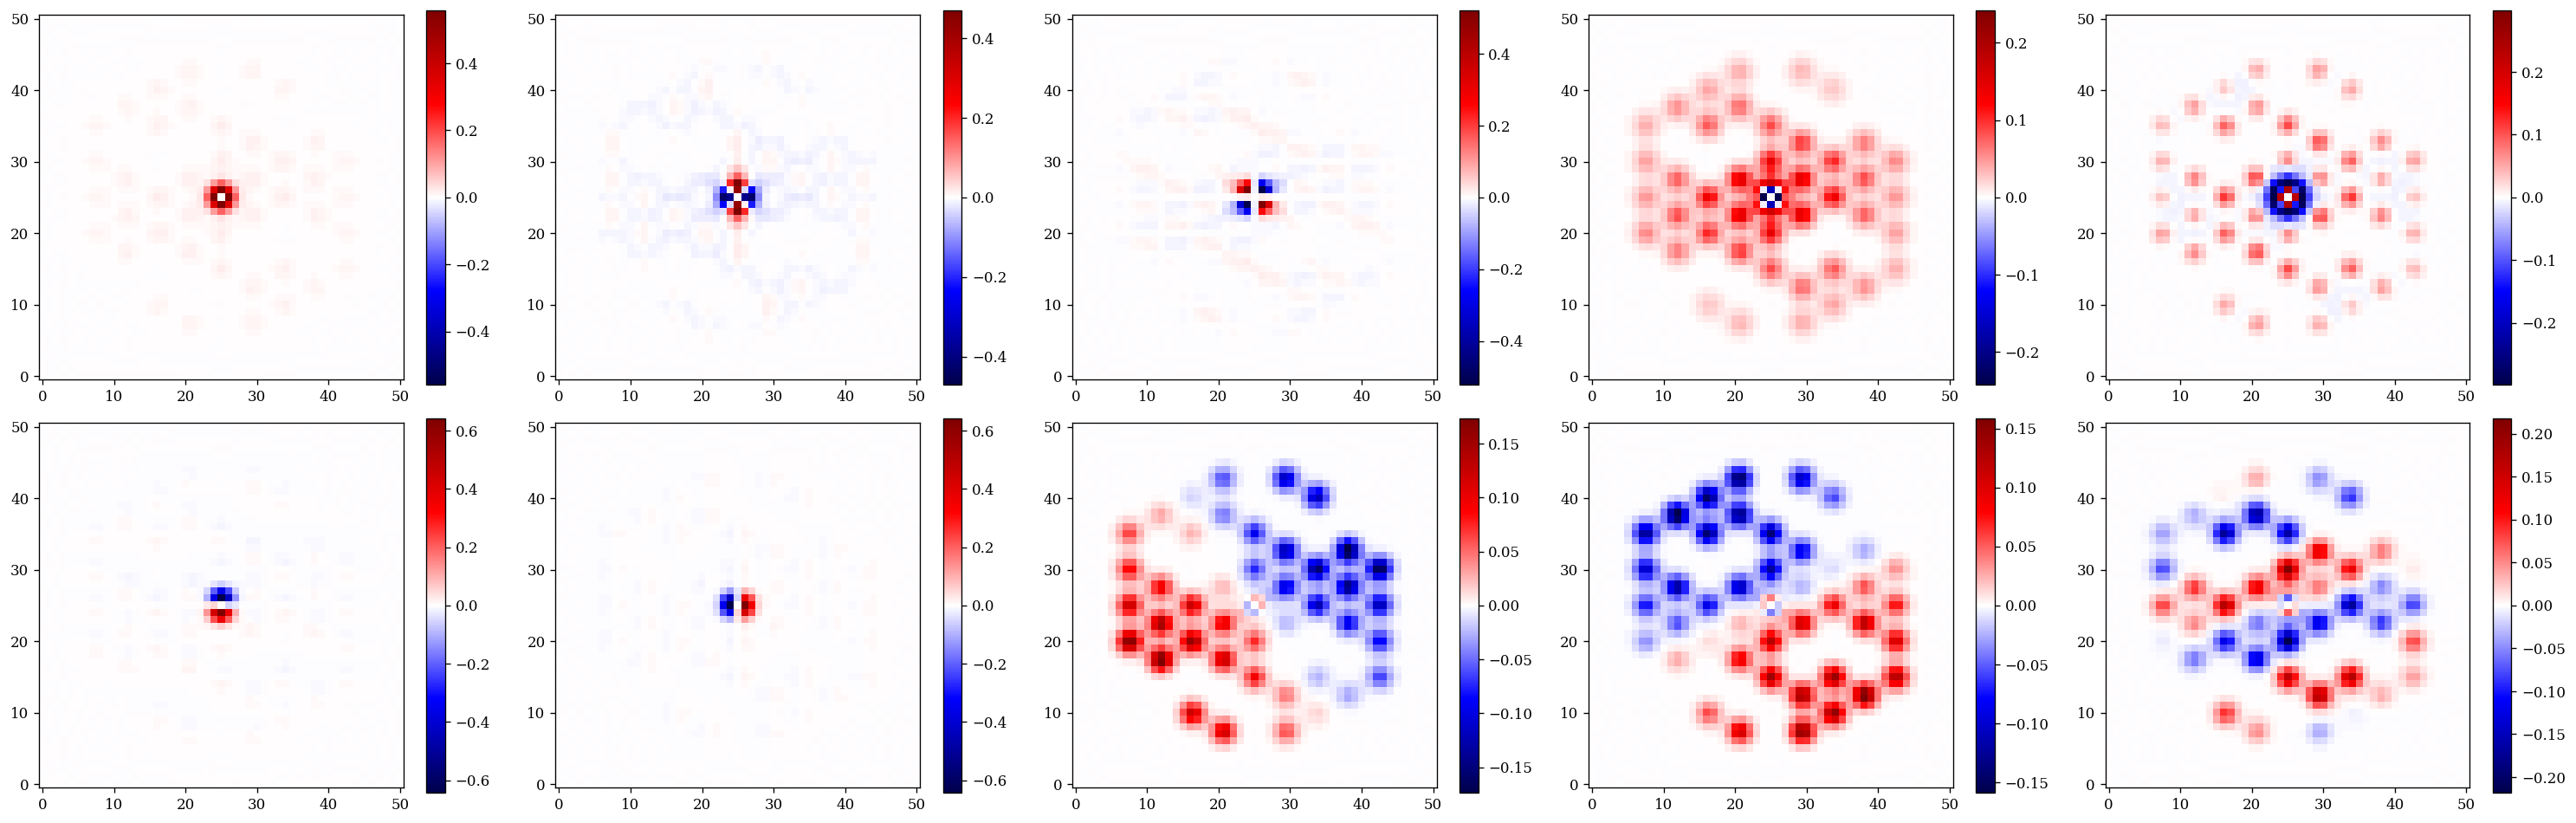

In [55]:
plt.figure(figsize=(25, 8))
for i in range(5):
    amp, phase = vis_to_im(amp_vecs[i], phase_vecs[i], (51, 51))
    amp = amp - 1

    v = np.nanmax(np.abs(amp))
    plt.subplot(2, 5, i + 1)
    plt.imshow(amp, seismic, vmin=-v, vmax=v)
    plt.colorbar()

    v = np.nanmax(np.abs(phase))
    plt.subplot(2, 5, i + 6)
    plt.imshow(phase, seismic, vmin=-v, vmax=v)
    plt.colorbar()

plt.tight_layout()
plt.show()

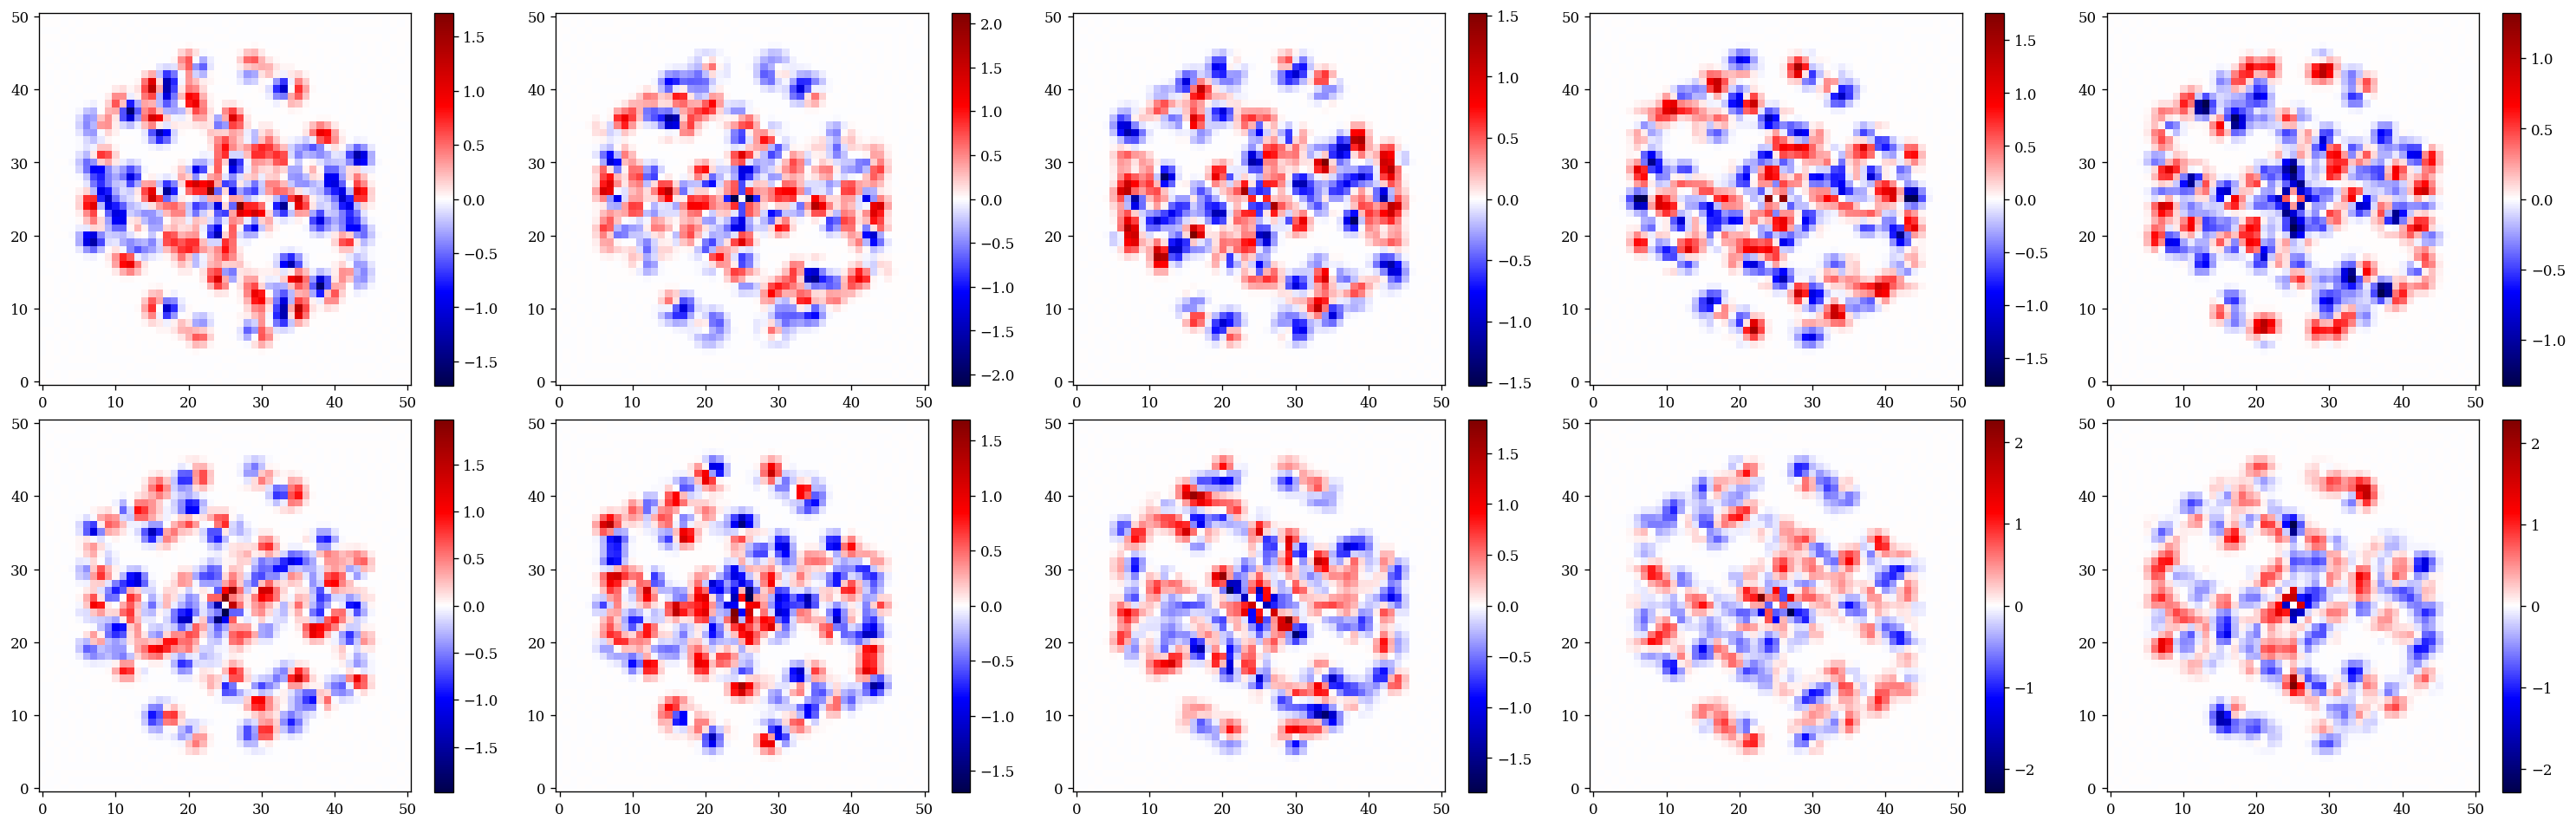

In [56]:
n_basis = 100

plt.figure(figsize=(25, 8))
for i in range(5):
    latent_amp, latent_phase = jr.normal(jr.key(i), (2, n_basis))
    amp = np.dot(latent_amp, amp_vecs[:n_basis])
    phase = np.dot(latent_phase, phase_vecs[:n_basis])
    amp, phase = vis_to_im(amp, phase, (51, 51))
    amp = amp - 1

    v = np.nanmax(np.abs(amp))
    plt.subplot(2, 5, i + 1)
    plt.imshow(amp, seismic, vmin=-v, vmax=v)
    plt.colorbar()

    v = np.nanmax(np.abs(phase))
    plt.subplot(2, 5, i + 6)
    plt.imshow(phase, seismic, vmin=-v, vmax=v)
    plt.colorbar()

plt.tight_layout()
plt.show()

In [57]:
import zodiax as zdx
from amigo.misc import interp
import dLux as dl


class VisModel(zdx.Base):
    amp_matrix: dict
    phase_matrix: dict
    otf_coords: np.ndarray
    n_knots: int = eqx.field(static=True)
    n_terms: int = eqx.field(static=True)

    def __init__(self, amp_matrix, phase_matrix, otf_coords, n_terms=100):
        self.amp_matrix = jtu.map(lambda x: x[:n_terms], amp_matrix)
        self.phase_matrix = jtu.map(lambda x: x[:n_terms], phase_matrix)
        self.otf_coords = np.array(otf_coords, float)
        self.n_terms = int(n_terms)
        self.n_knots = int(otf_coords.shape[-1])

    def model_vis(self, wfs, amps, phases, filter):
        uv_coords = wf_fft_coords(wfs, pad=2)
        amp = np.dot(amps, self.amp_matrix[filter])
        phase = np.dot(phases, self.phase_matrix[filter])
        psf = inject_vis(wfs.psf, amp, phase, self.otf_coords, uv_coords)
        return dl.PSF(psf, wfs.pixel_scale.mean(0))


otf_coords = dlu.pixel_coords(51, 2 * optics.diameter)
vis_model = VisModel(
    eig_mats["amplitude"],
    eig_mats["phase"],
    otf_coords,
    n_terms=450,
)